In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering

pd.set_option("display.max_columns", 80)
pd.set_option("display.width", 160)

DATA_GOLD = Path("data/gold")

In [2]:
features = pd.read_csv(DATA_GOLD / "pokemon_power_score.csv")
features.shape

(1328, 32)

In [3]:
df = features.copy()

df["offensive_type_score"] = df["offensive_effectiveness"]
df["defensive_type_score"] = 1.0 / df["defensive_multiplier_mean"].replace(0, np.nan)
df["defensive_type_score"] = df["defensive_type_score"].fillna(df["defensive_type_score"].median())

df[[
    "name", "type_1", "type_2",
    "offensive_effectiveness", "offensive_type_score",
    "defensive_multiplier_mean", "defensive_type_score"
]].head()

,name,type_1,type_2,offensive_effectiveness,offensive_type_score,defensive_multiplier_mean,defensive_type_score
0,bulbasaur,grass,poison,0.964286,0.964286,1.059524,0.94382
1,ivysaur,grass,poison,0.964286,0.964286,1.059524,0.94382
2,venusaur,grass,poison,0.964286,0.964286,1.059524,0.94382
3,charmander,fire,NaN,1.095238,1.095238,1.000000,1.00000
4,charmeleon,fire,NaN,1.095238,1.095238,1.000000,1.00000


In [4]:
feature_cols = [
    "total_base_stats",
    "hp", "attack", "defense", "special-attack", "special-defense", "speed",
    "mean_move_power", "max_move_power",
    "offensive_type_score",
    "defensive_type_score",
]

X = df[feature_cols].copy()

# Rellenamos posibles NaN (por seguridad) con la media de la columna
X = X.fillna(X.mean())
X.head()

,total_base_stats,hp,attack,defense,special-attack,special-defense,speed,mean_move_power,max_move_power,offensive_type_score,defensive_type_score
0,318,45,49,49,65,65,45,67.954545,130.0,0.964286,0.94382
1,405,60,62,63,80,80,60,66.219512,130.0,0.964286,0.94382
2,525,80,82,83,100,100,80,73.076923,150.0,0.964286,0.94382
3,309,39,52,43,60,50,65,72.397059,150.0,1.095238,1.00000
4,405,58,64,58,80,65,80,72.772727,150.0,1.095238,1.00000


In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled.shape

(1328, 11)

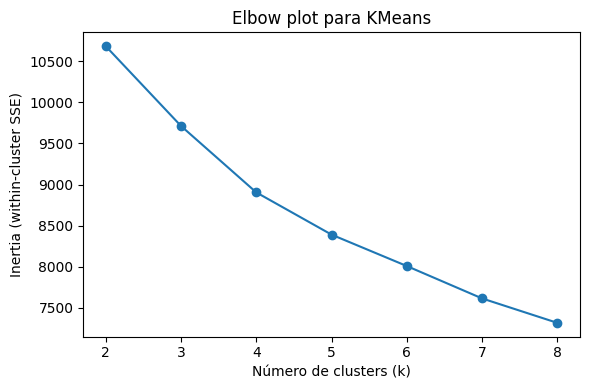

In [7]:
inertias = []
K_range = range(2, 9)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K_range, inertias, marker="o")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inertia (within-cluster SSE)")
plt.title("Elbow plot para KMeans")
plt.xticks(K_range)
plt.tight_layout()
plt.show()

In [12]:
k =4
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
cluster_labels = kmeans.fit_predict(X_scaled)

df["cluster_kmeans"] = cluster_labels
df["cluster_kmeans"].value_counts().sort_index()

cluster_kmeans
0    394
1    571
2    132
3    231
Name: count, dtype: int64

In [13]:
df[[
    "name", "type_1", "type_2",
    "total_base_stats",
    "attack", "special-attack", "defense", "special-defense", "hp", "speed",
    "mean_move_power", "max_move_power",
    "offensive_type_score", "defensive_type_score",
    "cluster_kmeans"
]].sample(10, random_state=42)

,name,type_1,type_2,total_base_stats,attack,special-attack,defense,special-defense,hp,speed,mean_move_power,max_move_power,offensive_type_score,defensive_type_score,cluster_kmeans
1201,darmanitan-galar-standard,ice,NaN,480,140,30,55,55,105,95,84.148936,150.0,1.095238,0.857143,1
115,horsea,water,NaN,295,40,70,70,25,30,60,70.813953,130.0,1.071429,1.000000,0
979,clodsire,poison,ground,430,75,45,60,100,130,20,81.153846,150.0,1.047619,0.988235,1
175,togetic,fairy,flying,405,40,80,85,105,55,40,77.187500,150.0,1.071429,0.976744,1
63,kadabra,psychic,NaN,400,35,120,30,70,40,105,81.046512,150.0,1.000000,0.913043,1
614,cryogonal,ice,NaN,515,50,95,50,135,80,105,76.756757,250.0,1.095238,0.857143,2
721,rowlet,grass,flying,320,55,50,55,50,68,42,64.634146,140.0,1.023810,0.831683,0
482,dialga,steel,dragon,680,120,150,120,100,100,90,80.000000,150.0,1.011905,1.217391,3
350,castform,normal,NaN,420,70,70,70,70,70,70,76.447368,140.0,0.904762,1.000000,1
543,whirlipede,bug,poison,360,55,40,99,79,40,47,64.814815,130.0,0.964286,0.954545,0


In [14]:
cluster_profile = (
    df.groupby("cluster_kmeans")[feature_cols + ["offensive_score", "defensive_score", "power_score_final"]]
    .mean()
)

cluster_profile

,total_base_stats,hp,attack,defense,special-attack,special-defense,speed,mean_move_power,max_move_power,offensive_type_score,defensive_type_score,offensive_score,defensive_score,power_score_final
cluster_kmeans,,,,,,,,,,,,,,
0,303.822335,49.418782,54.251269,49.522843,48.439086,49.192893,52.997462,68.871815,130.271318,1.018310,0.964042,0.391975,0.126483,0.285778
1,479.520140,78.945709,89.984238,81.112084,75.768827,78.760070,74.949212,74.728820,148.429907,1.025352,0.966141,0.475604,0.277537,0.396377
2,457.780303,69.265152,80.590909,92.257576,77.553030,76.166667,61.946970,81.375453,245.833333,1.044102,0.963402,0.698011,0.267781,0.525919
3,617.787879,92.341991,111.844156,98.207792,114.138528,101.082251,100.173160,79.022069,151.787440,1.027984,0.949681,0.515369,0.376228,0.459712


In [26]:
# Índices ofensivo y defensivo A NIVEL POKÉMON
df["offense_index"] = df[[
    "attack", "special-attack", "speed",
    "max_move_power", "offensive_type_score"
]].mean(axis=1)

df["defense_index"] = df[[
    "hp", "defense", "special-defense",
    "defensive_type_score"
]].mean(axis=1)

df[["name", "offense_index", "defense_index"]].head()

,name,offense_index,defense_index
0,bulbasaur,57.992857,39.985955
1,ivysaur,66.592857,50.985955
2,venusaur,82.592857,65.985955
3,charmander,65.619048,33.250000
4,charmeleon,75.019048,45.500000


In [27]:
cluster_profile = (
    df
    .groupby("cluster_kmeans")[[
        "offense_index", "defense_index",
        "total_base_stats", "mean_move_power", "max_move_power"
    ]]
    .mean()
)

cluster_profile.round(2)

,offense_index,defense_index,total_base_stats,mean_move_power,max_move_power
cluster_kmeans,,,,,
0,57.05,37.27,303.82,68.87,130.27
1,76.94,59.95,479.52,74.73,148.43
2,93.39,59.66,457.78,81.38,245.83
3,94.33,73.15,617.79,79.02,151.79


In [28]:
role_mapping = {
    0: "Support / Utility",
    1: "Bruiser / All-Rounder",
    2: "Glass Cannon",
    3: "Powerhouse Tank",
}

df["role_kmeans"] = df["cluster_kmeans"].map(role_mapping)
df["role_kmeans"].value_counts()

role_kmeans
Bruiser / All-Rounder    571
Support / Utility        394
Powerhouse Tank          231
Glass Cannon             132
Name: count, dtype: int64

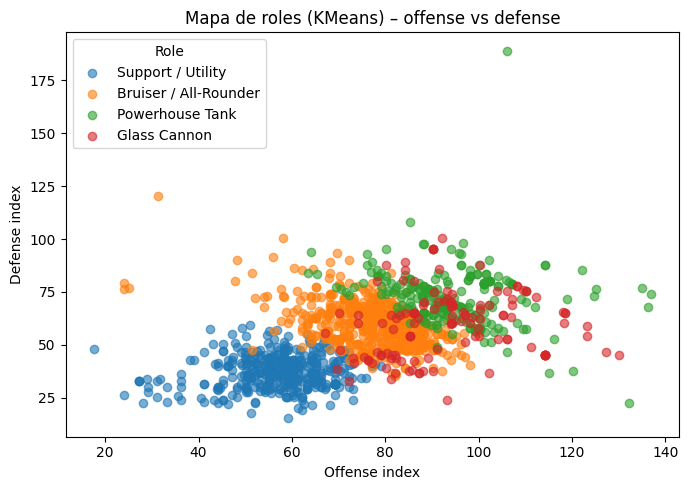

In [30]:
plt.figure(figsize=(7, 5))

roles_unique = df["role_kmeans"].unique()
colors = {role: i for i, role in enumerate(roles_unique)}

for role in roles_unique:
    subset = df[df["role_kmeans"] == role]
    plt.scatter(
        subset["offense_index"],
        subset["defense_index"],
        alpha=0.6,
        label=role
    )

plt.xlabel("Offense index")
plt.ylabel("Defense index")
plt.title("Mapa de roles (KMeans) – offense vs defense")
plt.legend(title="Role")
plt.tight_layout()
plt.show()

In [31]:
from pathlib import Path

DATA_GOLD = Path("data/gold")
DATA_GOLD.mkdir(parents=True, exist_ok=True)

out_clusters = DATA_GOLD / "pokemon_clusters_roles.csv"

df_to_save = df[[
    "id", "name", "type_1", "type_2",
    "total_base_stats",
    "hp", "attack", "defense", "special-attack", "special-defense", "speed",
    "mean_move_power", "max_move_power",
    "offensive_type_score", "defensive_type_score",
    "offense_index", "defense_index",
    "offensive_score", "defensive_score", "power_score_final",
    "cluster_kmeans", "role_kmeans"
]]

df_to_save.to_csv(out_clusters, index=False)
out_clusters

PosixPath('data/gold/pokemon_clusters_roles.csv')

In [32]:
df_to_save.head()

,id,name,type_1,type_2,total_base_stats,hp,attack,defense,special-attack,special-defense,speed,mean_move_power,max_move_power,offensive_type_score,defensive_type_score,offense_index,defense_index,offensive_score,defensive_score,power_score_final,cluster_kmeans,role_kmeans
0,1,bulbasaur,grass,poison,318,45,49,49,65,65,45,67.954545,130.0,0.964286,0.94382,57.992857,39.985955,0.355158,0.138973,0.268684,0,Support / Utility
1,2,ivysaur,grass,poison,405,60,62,63,80,80,60,66.219512,130.0,0.964286,0.94382,66.592857,50.985955,0.382632,0.211920,0.314347,0,Support / Utility
2,3,venusaur,grass,poison,525,80,82,83,100,100,80,73.076923,150.0,0.964286,0.94382,82.592857,65.985955,0.460526,0.311968,0.401103,1,Bruiser / All-Rounder
3,4,charmander,fire,NaN,309,39,52,43,60,50,65,72.397059,150.0,1.095238,1.00000,65.619048,33.250000,0.502316,0.119384,0.349143,0,Support / Utility
4,5,charmeleon,fire,NaN,405,58,64,58,80,65,80,72.772727,150.0,1.095238,1.00000,75.019048,45.500000,0.532632,0.202655,0.400641,1,Bruiser / All-Rounder
